# 1. Dataset Preparation

## Overview

In this phase, a startups dataset will be properly created and prepared for further feature analysis. Different features will be created here by combining information from the CSV files we have available: *acquisitions.csv*, *investments.csv*, *rounds.csv* and *companies.csv*.

## Load all available data from CSV general files

In [1]:
#All imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime
from dateutil import relativedelta

%matplotlib inline

In [2]:
#Let's start by importing our csv files into dataframes
df_companies = pd.read_csv('data/companies.csv')
df_acquisitions = pd.read_csv('data/acquisitions.csv')
df_investments = pd.read_csv('data/investments.csv')
df_rounds = pd.read_csv('data/rounds.csv')

## Start main dataset by USA companies from companies.csv

We'll be using in the analysis only USA based companies since companies from other countries have a large amount of missing data

In [3]:
#Our final database will be stored in 'startups_USA'

startups_USA = df_companies[df_companies['country_code'] == 'USA']
startups_USA.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24
7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01,2013-01-03,2015-11-09
8,/organization/1,One Inc.,http://whatis1.com,Mobile,1150050,operating,USA,CA,SF Bay Area,San Francisco,3,2011-08-01,2011-07-20,2014-02-05
10,/organization/1-4-all,1-4 All,NaN,Entertainment|Games|Software,-,operating,USA,NC,NC - Other,Connellys Springs,1,NaN,2013-04-21,2013-04-21


## Extract company category features

Now that we have a first version of our dataset, we'll expand the category_list attribute into dummy variables for categories.

There are in total 60813 different categories
Software               2326
Mobile                 2119
Social Media           1246
Enterprise Software    1141
E-Commerce             1137
dtype: int64


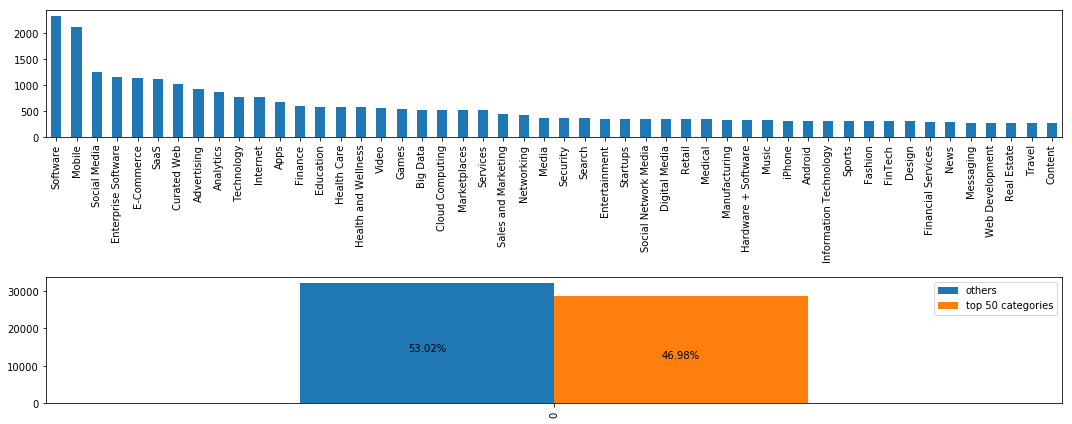

In [6]:
from operator import methodcaller

def split_categories(categories):
    #get a unique list of the categories
    splitted_categories = list(categories.astype('str').unique())

    #split each category by |
    splitted_categories = map(methodcaller("split", "|"), splitted_categories)

    #flatten the list of sub categories
    splitted_categories = [item for sublist in splitted_categories for item in sublist]
    
    return splitted_categories

def explore_categories(categories, top_n_categories):
    
    cat = split_categories(categories)

    print 'There are in total {} different categories'.format(len(cat))
    prob = pd.Series(cat).value_counts()
    print prob.head()
    #select first <top_n_categories>
    mask = prob > prob[top_n_categories]
    head_prob = prob.loc[mask].sum()
    tail_prob = prob.loc[~mask].sum()
    total_sum = prob.sum()
    prob = prob.loc[mask]
    prob2 = pd.DataFrame({'top '+str(top_n_categories)+' categories': head_prob, 'others': tail_prob},index=[0])

    fig, axs = plt.subplots(2,1, figsize=(15,6))
    prob.plot(kind='bar', ax=axs[0])
    prob2.plot(kind='bar', ax=axs[1])
    for bar in axs[1].patches:
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2., 0.50*height, '%.2f' % (float(height)/float(total_sum)*100) + "%", ha='center', va='top')
    fig.tight_layout()
    
    plt.xticks(rotation=90)
    plt.show()
    
    
    
explore_categories(startups_USA['category_list'], top_n_categories=50)    

Since there are too many categories, we'll be selecting the top 50 more frequent ones.

We see from the chart above, that with these 50 (out of 60813) categories we cover 46% of the companies.

In [7]:
def expand_top_categories_into_dummy_variables(df):
    cat = df['category_list'].astype('str')
    cat_count = cat.str.split('|').apply(lambda x: pd.Series(x).value_counts()).sum()
    #Get a dummy dataset for categories
    dummies = cat.str.get_dummies(sep='|')
    #Count of categories splitted first 50)
    top50categories = list(cat_count.sort_values(ascending=False).index[:50])
    #Create a dataframe with the 50 top categories to be concatenated later to the complete dataframe
    categories_df = dummies[top50categories]
    categories_df = categories_df.add_prefix('Category_')
    return pd.concat([df, categories_df], axis=1, ignore_index=False)
    

startups_USA = expand_top_categories_into_dummy_variables(startups_USA)

In [8]:
startups_USA.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,...,Category_Music,Category_Search,Category_Semiconductors,Category_Information Technology,Category_FinTech,Category_Retail,Category_Financial Services,Category_Messaging,Category_Social Network Media,Category_Startups
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,...,0,0,0,0,0,0,0,0,1,0
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,...,0,0,0,0,0,0,0,0,0,0
7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,...,0,0,0,0,0,0,0,0,0,0
8,/organization/1,One Inc.,http://whatis1.com,Mobile,1150050,operating,USA,CA,SF Bay Area,San Francisco,...,0,0,0,0,0,0,0,0,0,0
10,/organization/1-4-all,1-4 All,NaN,Entertainment|Games|Software,-,operating,USA,NC,NC - Other,Connellys Springs,...,0,0,0,0,0,0,0,0,0,0


So now we added more 50 categories to our dataset.

## Analyzing total funding and funding round features

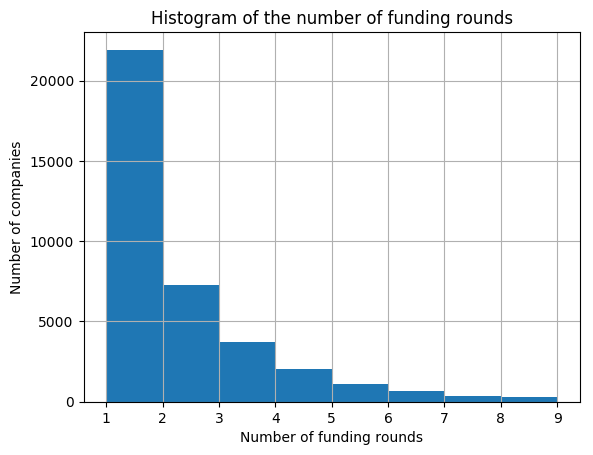

In [84]:
startups_USA['funding_rounds'].hist(bins=range(1,10))
plt.title("Histogram of the number of funding rounds")
plt.ylabel('Number of companies')
plt.xlabel('Number of funding rounds')

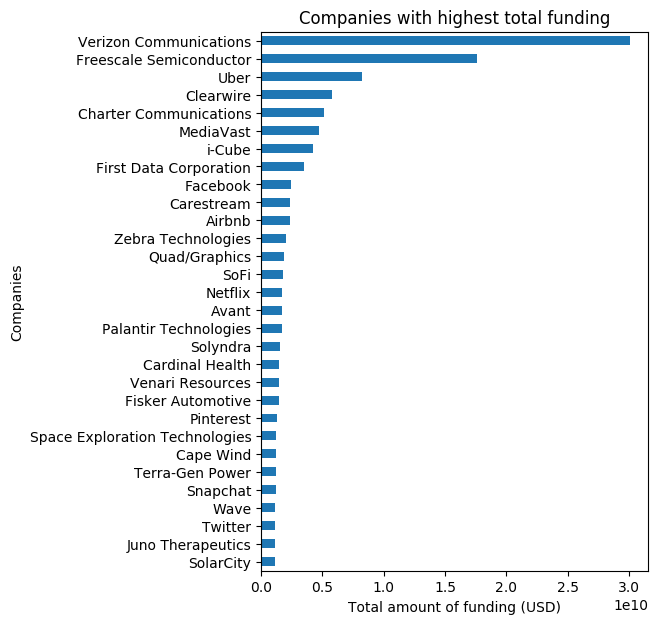

In [86]:
#funding_total_usd
#funding_rounds
plt.subplot()
startups_USA[startups_USA['funding_total_usd'] != '-']. \
    set_index('name')['funding_total_usd'] \
    .astype(float) \
    .sort_values(ascending=False)\
    [:30].plot(kind='barh', figsize=(5,7))
plt.gca().invert_yaxis()
plt.title('Companies with highest total funding')
plt.ylabel('Companies')
plt.xlabel('Total amount of funding (USD)')
    
    

## Analyzing date variables

## Extract investment rounds features

Here, we'll extract from the rounds.csv file the number of rounds and total amount invested for each different type of investment.

In [7]:
# Investment types
df_rounds['funding_round_type'].value_counts()

venture                  55494
seed                     30524
debt_financing            6895
angel                     6094
undisclosed               4897
equity_crowdfunding       3257
private_equity            2285
grant                     2200
convertible_note          1817
post_ipo_equity            638
product_crowdfunding       410
non_equity_assistance      191
post_ipo_debt              152
secondary_market            95
Name: funding_round_type, dtype: int64

In [8]:
import warnings
warnings.filterwarnings('ignore')

#Iterate over each kind of funding type, and add two new features for each into the dataframe
def add_dummy_for_funding_type(df, aggr_rounds, funding_type):
    funding_df = aggr_rounds.iloc[aggr_rounds.index.get_level_values('funding_round_type') == funding_type].reset_index()
    funding_df.columns = funding_df.columns.droplevel()
    funding_df.columns = ['company_permalink', funding_type, funding_type+'_funding_total_usd', funding_type+'_funding_rounds']
    funding_df = funding_df.drop(funding_type,1)
    
    new_df = pd.merge(df, funding_df, on='company_permalink', how='left')
    new_df = new_df.fillna(0)
    return new_df

def expand_investment_rounds(df, df_rounds):
    #Prepare an aggregated rounds dataframe grouped by company and funding type
    rounds_agg = df_rounds.groupby(['company_permalink', 'funding_round_type'])['raised_amount_usd'].agg({'amount': [ pd.Series.sum, pd.Series.count]})
    #Get available unique funding types
    funding_types = list(rounds_agg.index.levels[1])
    
    #Prepare the dataframe where all the dummy features for each funding type will be added (number of rounds and total sum for each type)
    rounds_df = df[['permalink']]
    rounds_df = rounds_df.rename(columns = {'permalink':'company_permalink'})
    
    #For each funding type, add two more columns to rounds_df
    for funding_type in funding_types:
        rounds_df = add_dummy_for_funding_type(rounds_df, rounds_agg, funding_type)

    #remove the company_permalink variable, since it's already available in the companies dataframe
    rounds_df = rounds_df.drop('company_permalink', 1)

    #set rounds_df to have the same index of the other dataframes
    rounds_df.index = df.index

    return pd.concat([df, rounds_df], axis=1, ignore_index=False)
    
    
    
    
startups_USA = expand_investment_rounds(startups_USA, df_rounds)

In [9]:
startups_USA.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,...,product_crowdfunding_funding_total_usd,product_crowdfunding_funding_rounds,secondary_market_funding_total_usd,secondary_market_funding_rounds,seed_funding_total_usd,seed_funding_rounds,undisclosed_funding_total_usd,undisclosed_funding_rounds,venture_funding_total_usd,venture_funding_rounds
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,...,0.0,0.0,0.0,0.0,700000.0,1.0,0.0,0.0,0.0,0.0
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,...,0.0,0.0,0.0,0.0,3000000.0,1.0,0.0,0.0,30600000.0,3.0
8,/organization/1,One Inc.,http://whatis1.com,Mobile,1150050,operating,USA,CA,SF Bay Area,San Francisco,...,0.0,0.0,0.0,0.0,1150050.0,2.0,0.0,0.0,0.0,0.0
10,/organization/1-4-all,1-4 All,NaN,Entertainment|Games|Software,-,operating,USA,NC,NC - Other,Connellys Springs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Change dataset index

We'll set the company id (**permalink** attribute) as the index for the dataset. This simple change will make it easier to attach new features to the dataset.

In [10]:
startups_USA = startups_USA.set_index('permalink')

## Extract acquisitions features

Here, we'll extract the number of acquisitions were made by each company in our dataset.

In [11]:
import warnings
warnings.filterwarnings('ignore')

def extract_feature_number_of_acquisitions(df, df_acquisitions):
    number_of_acquisitions = df_acquisitions.groupby(['acquirer_permalink'])['acquirer_permalink'].agg({'amount': [ pd.Series.count]}).reset_index()
    number_of_acquisitions.columns = number_of_acquisitions.columns.droplevel()
    number_of_acquisitions.columns = ['permalink', 'number_of_acquisitions']
    number_of_acquisitions = number_of_acquisitions.set_index('permalink')
    number_of_acquisitions = number_of_acquisitions.fillna(0)
    new_df = df.join(number_of_acquisitions)
    new_df['number_of_acquisitions'] = new_df['number_of_acquisitions'].fillna(0)
    return new_df

startups_USA = extract_feature_number_of_acquisitions(startups_USA, df_acquisitions)

## Extract investments feature

Here, we'll extract the number of investments made by each company in our dataset.

Note: This is not the number of times in which someone invested in the startup. It is the number of times in which each startup have made an investment in other company.

In [12]:
import warnings
warnings.filterwarnings('ignore')

def extract_feature_number_of_investments(df, df_investments):
    number_of_investments = df_investments.groupby(['investor_permalink'])['investor_permalink'].agg({'amount': [ pd.Series.count]}).reset_index()
    number_of_investments.columns = number_of_investments.columns.droplevel()
    number_of_investments.columns = ['permalink', 'number_of_investments']
    number_of_investments = number_of_investments.set_index('permalink')
    
    number_of_unique_investments = df_investments.groupby(['investor_permalink'])['company_permalink'].agg({'amount': [ pd.Series.nunique]}).reset_index()
    number_of_unique_investments.columns = number_of_unique_investments.columns.droplevel()
    number_of_unique_investments.columns = ['permalink', 'number_of_unique_investments']
    number_of_unique_investments = number_of_unique_investments.set_index('permalink')
    
    new_df = df.join(number_of_investments)
    new_df['number_of_investments'] = new_df['number_of_investments'].fillna(0)
    new_df = new_df.join(number_of_unique_investments)
    new_df['number_of_unique_investments'] = new_df['number_of_unique_investments'].fillna(0)
    return new_df


startups_USA = extract_feature_number_of_investments(startups_USA, df_investments)


## Extract average number of investors and amount invested per round

Here we'll extract two more features

- The average number of investors that participated in each around of investment
- The average amount invested among all the investment rounds a startup had

In [13]:
import warnings
warnings.filterwarnings('ignore')

def extract_feature_avg_investors_per_round(df, investments):
    number_of_investors_per_round = investments.groupby(['company_permalink', 'funding_round_permalink'])['investor_permalink'].agg({'investor_permalink': [ pd.Series.count]}).reset_index()
    number_of_investors_per_round.columns = number_of_investors_per_round.columns.droplevel(0)
    number_of_investors_per_round.columns = ['company_permalink', 'funding_round_permalink', 'count']
    number_of_investors_per_round = number_of_investors_per_round.groupby(['company_permalink']).agg({'count': [ pd.Series.mean]}).reset_index()
    number_of_investors_per_round.columns = number_of_investors_per_round.columns.droplevel(0)
    number_of_investors_per_round.columns = ['company_permalink', 'number_of_investors_per_round']
    number_of_investors_per_round = number_of_investors_per_round.set_index('company_permalink')
    
    
    new_df = df.join(number_of_investors_per_round)
    new_df['number_of_investors_per_round'] = new_df['number_of_investors_per_round'].fillna(-1)
    return new_df

def extract_feature_avg_amount_invested_per_round(df, investments):
    investmentsdf = investments.copy()
    investmentsdf['raised_amount_usd'] = investmentsdf['raised_amount_usd'].astype(float)
    avg_amount_invested_per_round = investmentsdf.groupby(['company_permalink', 'funding_round_permalink'])['raised_amount_usd'].agg({'raised_amount_usd': [ pd.Series.mean]}).reset_index()
    avg_amount_invested_per_round.columns = avg_amount_invested_per_round.columns.droplevel(0)
    avg_amount_invested_per_round.columns = ['company_permalink', 'funding_round_permalink', 'mean']
    avg_amount_invested_per_round = avg_amount_invested_per_round.groupby(['company_permalink']).agg({'mean': [ pd.Series.mean]}).reset_index()
    avg_amount_invested_per_round.columns = avg_amount_invested_per_round.columns.droplevel(0)
    avg_amount_invested_per_round.columns = ['company_permalink', 'avg_amount_invested_per_round']
    avg_amount_invested_per_round = avg_amount_invested_per_round.set_index('company_permalink')
    
    new_df = df.join(avg_amount_invested_per_round)
    new_df['avg_amount_invested_per_round'] = new_df['avg_amount_invested_per_round'].fillna(-1)
    return new_df


startups_USA = extract_feature_avg_investors_per_round(startups_USA, df_investments)
startups_USA = extract_feature_avg_amount_invested_per_round(startups_USA, df_investments)


In [14]:
startups_USA.head()

,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,seed_funding_rounds,undisclosed_funding_total_usd,undisclosed_funding_rounds,venture_funding_total_usd,venture_funding_rounds,number_of_acquisitions,number_of_investments,number_of_unique_investments,number_of_investors_per_round,avg_amount_invested_per_round
permalink,,,,,,,,,,,,,,,,,,,,,
/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.0
/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,-1.0
/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,4,...,1.0,0.0,0.0,30600000.0,3.0,0.0,0.0,0.0,3.500000,8400000.0
/organization/1,One Inc.,http://whatis1.com,Mobile,1150050,operating,USA,CA,SF Bay Area,San Francisco,3,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.333333,575025.0
/organization/1-4-all,1-4 All,NaN,Entertainment|Games|Software,-,operating,USA,NC,NC - Other,Connellys Springs,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.0


## Drop useless features

Here we'll drop homepage_url, category_list, region, city, country_code We'll also move status to the end of the dataframe

In [15]:
#drop features
startups_USA = startups_USA.drop(['name','homepage_url', 'category_list', 'region', 'city', 'country_code'], 1)

#move status to the end of the dataframe
cols = list(startups_USA)
cols.append(cols.pop(cols.index('status')))
startups_USA = startups_USA.ix[:, cols]

## Normalize numeric variables

Here we'll set all the numeric variables into the same scale (0 to 1)

In [29]:
def normalize_numeric_features(df, columns_to_scale = None):
    min_max_scaler = preprocessing.MinMaxScaler()
    startups_normalized = df.copy()

    #Convert '-' to zeros in funding_total_usd
    startups_normalized['funding_total_usd'] = startups_normalized['funding_total_usd'].replace('-', 0)

    #scale numeric features
    startups_normalized[columns_to_scale] = min_max_scaler.fit_transform(startups_normalized[columns_to_scale])
    return startups_normalized

columns_to_scale = list(startups_USA.filter(regex=(".*(funding_rounds|funding_total_usd)|(number_of|avg_).*")).columns)
startups_USA = normalize_numeric_features(startups_USA, columns_to_scale)

## Normalize date variables

Here we'll convert dates to ages in months up to the first day of 2017

In [34]:
def date_to_age_in_months(date):
    if date != date or date == 0: #is NaN
        return 0
    date1 = datetime.strptime(date, '%Y-%m-%d')
    date2 = datetime.strptime('2017-01-01', '%Y-%m-%d') #get age until 01/01/2017
    delta =  relativedelta.relativedelta(date2, date1)
    return delta.years * 12 + delta.months


def normalize_date_variables(df):
    date_vars = ['founded_at', 'first_funding_at', 'last_funding_at']
    for var in date_vars:
        df[var] = df[var].map(date_to_age_in_months)
        
    df = normalize_numeric_features(df, date_vars)
    return df
    
    
startups_USA = normalize_date_variables(startups_USA)

## Extract state_code features

There are in total 54 different states
CA    12900
NY     3952
MA     2542
TX     1995
FL     1295
Name: state_code, dtype: int64


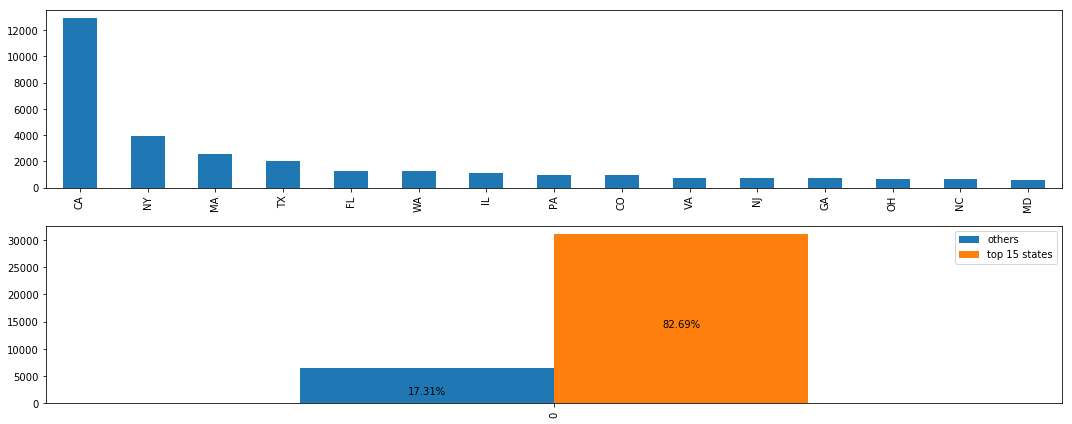

In [63]:
def explore_states(states, top_n_states):

    print 'There are in total {} different states'.format(len(states.unique()))
    prob = pd.Series(states).value_counts()
    print prob.head()
    #select first <top_n_categories>
    mask = prob > prob[top_n_states]
    head_prob = prob.loc[mask].sum()
    tail_prob = prob.loc[~mask].sum()
    total_sum = prob.sum()
    prob = prob.loc[mask]
    prob2 = pd.DataFrame({'top '+str(top_n_states)+' states': head_prob, 'others': tail_prob},index=[0])

    fig, axs = plt.subplots(2,1, figsize=(15,6))
    prob.plot(kind='bar', ax=axs[0])
    prob2.plot(kind='bar', ax=axs[1])
    for bar in axs[1].patches:
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2., 0.50*height, '%.2f' % (float(height)/float(total_sum)*100) + "%", ha='center', va='top')
    fig.tight_layout()
    
    plt.xticks(rotation=90)
    plt.show()
    
    
    
explore_states(startups_USA['state_code'], top_n_states=15)    

As we did for the categories variable, in order to decrease the amount of features in our dataset, let's just select the top 15 more frequent states (which cover already 82% of our companies)

In [65]:
def expand_top_states_into_dummy_variables(df):
    states = df['state_code'].astype('str')
    
    #Get a dummy dataset for categories
    dummies = pd.get_dummies(states)
    
    #select top most frequent states
    top15states = list(states.value_counts().sort_values(ascending=False).index[:15])
    
    #Create a dataframe with the 15 top states to be concatenated later to the complete dataframe
    states_df = dummies[top15states]
    states_df = states_df.add_prefix('State_')
    new_df = pd.concat([df, states_df], axis=1, ignore_index=False)
    new_df = new_df.drop(['state_code'], axis=1)
    return new_df
    
startups_USA = expand_top_states_into_dummy_variables(startups_USA)

## Move status to the end of dataframe and save to file

In [68]:
cols = list(startups_USA)
cols.append(cols.pop(cols.index('status')))
startups_USA = startups_USA.ix[:, cols]

In [71]:
startups_USA.to_csv('data/startups_pre_processed.csv')

In [72]:
startups_USA.head()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,Category_Software,Category_Biotechnology,Category_Mobile,Category_Enterprise Software,Category_E-Commerce,...,State_IL,State_PA,State_CO,State_VA,State_NJ,State_GA,State_OH,State_NC,State_MD,status
permalink,,,,,,,,,,,,,,,,,,,,,
/organization/-qounter,0.000023,0.055556,0.005917,0.002825,0.027344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,operating
/organization/004-technologies,0.000000,0.000000,0.018409,0.002410,0.033203,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,operating
/organization/0xdata,0.001117,0.166667,0.015779,0.003906,0.001953,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,operating
/organization/1,0.000038,0.111111,0.014245,0.005401,0.042969,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,operating
/organization/1-4-all,0.000000,0.000000,0.000000,0.003656,0.062500,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,operating
